<div style = "text-align: justify;">


# Apache Spark <font color =red>vs</font> No Spark

## Computo de Alto Desempeño


**Equipo:**

Jasmin del Rocio Coba Candanedo / 190300460

Oscar Manuel Castillo Torres / 190300399

Alexis Rodriguez Ramon / 170300123

### Profesora: **Candelaria E. Sansores**

El trabajo consiste en evaluar el desempeño de Machine Learning incluyendo el proceso de ETL con Spark en comparación con la versión sin paralelismo sin Spark. Para ello, necesitamos convertir la libreta de python con el análisis y creación de modelos de ML de datos bancarios en Spark en una versión sin Spark.


La comparación del desempeño de los procesos se hará de una manera simple, verificando el tiempo de ejecución de cada sección relevante del código en donde se haga uso de spark, por ejemplo, el manejo inicial de los datos (ETL), el modelo de regresión logística (LR), etc.
Presentar una tabla y gráfico que compare los tiempos.
Interpretar los resultados y discutirlo en las conclusiones.

</div>

#### Instalaciones necesarias para trabajar en collab, **java sdk** y **Apache Spark**.

In [ ]:
# Instalar Pyspark

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=582dcbcfa73e0f3f6c891a7a9492f20522705c24017ec48e8d195a4d42433a19
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Instalar Java 8

!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Apache SPARK

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.context import SparkContext


# Sin Spark
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Librerias para graficar y medir el tiempo de ejecución
import time
import matplotlib.pyplot as plt

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
# Configurar Spark

from pyspark import SparkContext, SparkConf
conf = SparkConf().set('spark.ui.port', '4050').setAppName("Bank").setMaster("local[2]")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)


In [ ]:
sc

<SparkContext master=local[2] appName=Bank>

### Importamos las librerias que vamos a utilizar para cada una de los entornos para el uso de <font color= Yellow>Machine Learning

## Creacion del entorno Spark Context

## **Extracción con Spark**

In [ ]:
# Aqui iniciamos el conteo del tiemmpo de ejecución del programa

start_time_spark = time.time()

In [ ]:
df = spark.read.csv('bank.csv',header = 'True',inferSchema='True')

In [ ]:
df.cache()
df.is_cached

True

In [ ]:
display(df)

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, deposit: string]

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [ ]:
df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   NULL|    NULL|     NULL|   NULL|1528.5385235620856|   NULL| NULL|    NULL

In [ ]:
df.count()                # 11162
#  How many columns?
len(df.columns)

17

In [ ]:
# Tiempo de finalización para la extracción con Spark
end_time_spark = time.time()

# Calcula el tiempo total para la extracción con Spark
elapsed_time_spark = end_time_spark - start_time_spark

## **Extracción sin Spark**

In [ ]:
# Tiempo de inicio para la extracción sin Spark
start_time_no_spark = time.time()

In [ ]:
ds = pd.read_csv('bank.csv', header=0)

In [ ]:
ds

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
ds.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
ds.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [ ]:
ds.count()

age          11162
job          11162
marital      11162
education    11162
default      11162
balance      11162
housing      11162
loan         11162
contact      11162
day          11162
month        11162
duration     11162
campaign     11162
pdays        11162
previous     11162
poutcome     11162
deposit      11162
dtype: int64

In [ ]:
len(df.columns)

17

In [ ]:
# Tiempo de finalización para la extracción sin Spark
end_time_no_spark = time.time()

# Calcula el tiempo total para la extracción sin Spark
elapsed_time_no_spark = end_time_no_spark - start_time_no_spark

# Imprime los resultados
print(f"Tiempo de ejecución con Spark: {elapsed_time_spark} segundos")
print(f"Tiempo de ejecución sin Spark: {elapsed_time_no_spark} segundos")

Tiempo de ejecución con Spark: 40.46485233306885 segundos
Tiempo de ejecución sin Spark: 0.2873404026031494 segundos


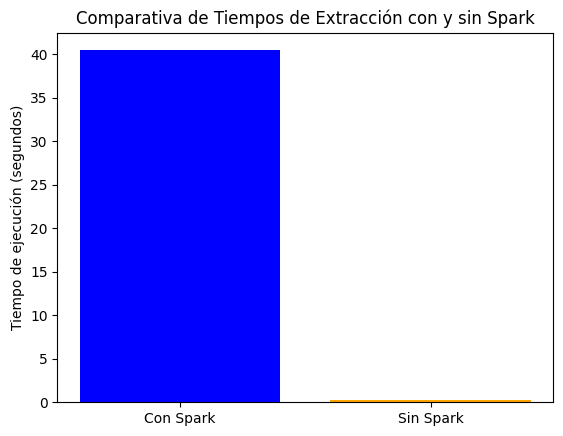

In [ ]:
labels = ['Con Spark', 'Sin Spark']
times = [elapsed_time_spark, elapsed_time_no_spark]

plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Comparativa de Tiempos de Extracción con y sin Spark')
plt.show()

## **Transfromación Con Spark**

In [ ]:
start_time_spark_transformation = time.time()

In [ ]:
df = df.select('age', 'job', 'marital', 'education', 'default',  'balance',
'housing', 'loan', 'contact', 'duration',  'campaign',
 'pdays', 'previous', 'poutcome', 'deposit')

df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|     673|       2|   -1|       0| unknown|    yes|
+---+----------+-------+

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.pipeline import Pipeline

In [ ]:
catCols = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'poutcome']
# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in catCols
]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol()))
    for indexer in indexers
]

# Vectorizing encoded values
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="rawFeatures")

numericCols = ['age', 'balance', 'duration',  'campaign', 'pdays', 'previous']

pipeline = Pipeline(stages=indexers + encoders+ [assembler])
model=pipeline.fit(df)
transformed = model.transform(df)
transformed.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+-----------+---------------+-----------------+---------------+---------------+------------+---------------+----------------+-------------------+-----------------------+-------------------------+-----------------------+-----------------------+--------------------+-----------------------+------------------------+--------------------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|job_indexed|marital_indexed|education_indexed|default_indexed|housing_indexed|loan_indexed|contact_indexed|poutcome_indexed|job_indexed_encoded|marital_indexed_encoded|education_indexed_encoded|default_indexed_encoded|housing_indexed_encoded|loan_indexed_encoded|contact_indexed_encoded|poutcome_indexed_encoded|         rawFeatures|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-

In [ ]:
transformed.select('rawFeatures').printSchema()


root
 |-- rawFeatures: vector (nullable = true)



In [ ]:
end_time_spark_transformation = time.time()

In [ ]:
elapsed_time_spark_transformation = end_time_spark_transformation - start_time_spark_transformation

## **Transformación sin Spark**

In [ ]:
start_time_no_spark_transformation = time.time()

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

# Supongamos que tienes un DataFrame llamado 'ds' con tus datos.
ds = pd.read_csv('bank.csv', header=0)

# Columnas categóricas
catCols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Columnas numéricas (excluyendo 'deposit' que es la etiqueta)
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Selecciona las características y la etiqueta
X = ds[numericCols + catCols]
y = ds['deposit']

# Definimos un preprocesador que manejará las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericCols),  # No necesita encoding
        ('cat', OneHotEncoder(drop='first'), catCols)
    ])

# Creamos un pipeline que incluye el preprocesamiento
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Medimos el tiempo de inicio
start_time = time.time()

# Ajustamos y transformamos los datos
transformed_data = pipeline.fit_transform(X)

# Medimos el tiempo de finalización
end_time = time.time()

# Calculamos el tiempo transcurrido
elapsed_time = end_time - start_time

# El resultado se encuentra en un formato de matriz NumPy
transformed_df = pd.DataFrame(transformed_data)

# Muestra las primeras 5 filas del DataFrame transformado
print(transformed_df.head(5))

# Muestra el tiempo de ejecución
print(f"Tiempo de ejecución: {elapsed_time} segundos")


     0       1       2    3    4    5    6    7    8    9   ...   20   21  \
0  59.0  2343.0  1042.0  1.0 -1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  56.0    45.0  1467.0  1.0 -1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  41.0  1270.0  1389.0  1.0 -1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  55.0  2476.0   579.0  1.0 -1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  54.0   184.0   673.0  2.0 -1.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   

    22   23   24   25   26   27   28   29  
0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
2  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  

[5 rows x 30 columns]
Tiempo de ejecución: 0.06888103485107422 segundos


In [ ]:
end_time_no_spark_transformation = time.time()

In [ ]:
elapsed_time_no_spark_transformation = end_time_no_spark_transformation - start_time_no_spark_transformation

Tiempos de Transformación:
   Con Spark  Sin Spark
0    8.03868   0.179106


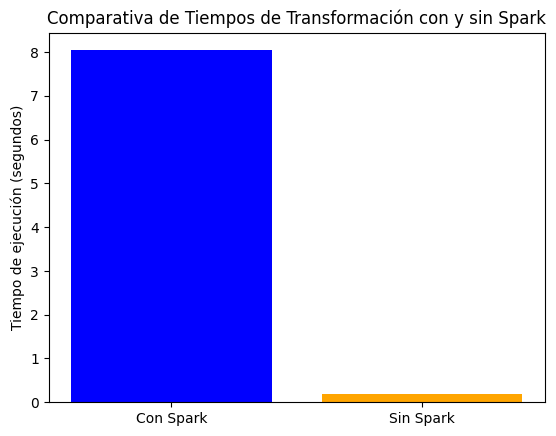

In [ ]:
# Guardamos los tiempos en un DataFrame para facilitar la presentación
transformation_data = {
    'Con Spark': [elapsed_time_spark_transformation],
    'Sin Spark': [elapsed_time_no_spark_transformation]
}

transformation_time_df = pd.DataFrame(transformation_data)

# Mostramos los tiempos en una tabla
print("Tiempos de Transformación:")
print(transformation_time_df)

# Mostramos los tiempos en un gráfico de barras
labels = ['Con Spark', 'Sin Spark']
times = [elapsed_time_spark_transformation, elapsed_time_no_spark_transformation]

plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Comparativa de Tiempos de Transformación con y sin Spark')
plt.show()

## Modelo de entrenamiento y prueba Con y sin Spark

## **Training con Spark**

In [ ]:
# Medimos el tiempo de inicio para la división de datos con Spark
start_time_spark_split = time.time()

# División de datos con Spark
(trainingData_spark, testData_spark) = transformed.randomSplit([0.7, 0.3], seed=11)

# Medimos el tiempo de finalización para la división de datos con Spark
end_time_spark_split = time.time()

# Calculamos el tiempo total para la división de datos con Spark
elapsed_time_spark_split = end_time_spark_split - start_time_spark_split

# Imprimimos la forma de los conjuntos de entrenamiento y prueba con Spark
print("Forma de trainingData (con Spark):", trainingData_spark.count())
print("Forma de testData (con Spark):", testData_spark.count())

Forma de trainingData (con Spark): 7825
Forma de testData (con Spark): 3337


In [ ]:
trainingData_spark.show(5)


+---+-------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+-------+-----------+---------------+-----------------+---------------+---------------+------------+---------------+----------------+-------------------+-----------------------+-------------------------+-----------------------+-----------------------+--------------------+-----------------------+------------------------+--------------------+
|age|    job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|deposit|job_indexed|marital_indexed|education_indexed|default_indexed|housing_indexed|loan_indexed|contact_indexed|poutcome_indexed|job_indexed_encoded|marital_indexed_encoded|education_indexed_encoded|default_indexed_encoded|housing_indexed_encoded|loan_indexed_encoded|contact_indexed_encoded|poutcome_indexed_encoded|         rawFeatures|
+---+-------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+-

## **Training Sin spark**

In [ ]:
from sklearn.model_selection import train_test_split
import time

# Supongamos que 'transformed_df' es tu DataFrame transformado

# Medimos el tiempo de inicio
start_time_spark_split = time.time()

# Divide los datos en conjuntos de entrenamiento y prueba (70% de entrenamiento, 30% de prueba)
trainingData, testData = train_test_split(transformed_df, test_size=0.3, random_state=11)

# Medimos el tiempo de finalización
end_time_spark_split = time.time()

# Calculamos el tiempo transcurrido
elapsed_time_no_spark_split = end_time_spark_split - start_time_spark_split

# Verifica las formas de los conjuntos de entrenamiento y prueba
print("Forma de trainingData:", trainingData.shape)
print("Forma de testData:", testData.shape)

# Muestra el tiempo de ejecución
print(f"Tiempo de ejecución para la división de datos: {elapsed_time} segundos")


Forma de trainingData: (7813, 30)
Forma de testData: (3349, 30)
Tiempo de ejecución para la división de datos: 0.06888103485107422 segundos


In [ ]:
# Guardamos los tiempos en un DataFrame para facilitar la presentación
split_data = {
    'Con Spark': [elapsed_time_spark_split],
    'Sin Spark': [elapsed_time_no_spark_split]
}

{'Con Spark': [0.03313088417053223], 'Sin Spark': [0.006376028060913086]}
Tiempos de Transformación:
   Con Spark  Sin Spark
0    8.03868   0.179106


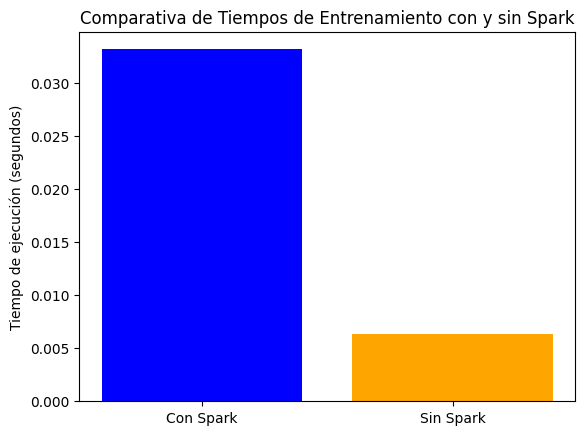

In [ ]:
print(split_data)
split_data_df = pd.DataFrame(split_data)

# Mostramos los tiempos en una tabla
print("Tiempos de Transformación:")
print(transformation_time_df)

# Mostramos los tiempos en un gráfico de barras
labels = ['Con Spark', 'Sin Spark']
times = [elapsed_time_spark_split, elapsed_time_no_spark_split]

plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Comparativa de Tiempos de Entrenamiento con y sin Spark')
plt.show()

## **Modelos de ML Con Spark**

* LogisticRegression

* DecisionTreeClassifier

* RadomForestClassifier

* Gradient-boosted tree classifier

* NaiveBayes

* support Vector Machine

## **LogisticRegression**

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time


def spark_total_tiempo(trainingData, testData):
    # Iniciar el cronómetro total
    total_start_time = time.time()

    # Entrenamiento del modelo
    lr = LogisticRegression(labelCol="loan_indexed", featuresCol="rawFeatures")
    lrModel = lr.fit(trainingData_spark)

    # Tiempo de entrenamiento
    training_time = time.time() - total_start_time
    print("Training Time: {} seconds".format(training_time))

    # Predicción
    lr_prediction = lrModel.transform(testData_spark)

    # Tiempo de predicción
    prediction_time = time.time() - total_start_time
    print("Prediction Time: {} seconds".format(prediction_time))

    # Mostrar resultados
    lr_prediction.select("prediction", "loan_indexed", "rawFeatures").show()

    # Evaluación
    evaluator = MulticlassClassificationEvaluator(labelCol="loan_indexed", predictionCol="prediction", metricName="accuracy")

    accuracy = evaluator.evaluate(lr_prediction)

    # Tiempo de evaluación
    evaluation_time = time.time() - total_start_time
    print("Accuracy:", accuracy)
    print("Evaluation Time: {} seconds".format(evaluation_time))

    # Tiempo total
    total_time = time.time() - total_start_time
    print("Total Time: {} seconds".format(total_time))

    return accuracy, total_time

# Llamar a la función con los conjuntos de datos de entrenamiento y prueba
accuracy, total_time = spark_total_tiempo(trainingData, testData)


Training Time: 9.947418451309204 seconds
Prediction Time: 10.109852313995361 seconds
+----------+------------+--------------------+
|prediction|loan_indexed|         rawFeatures|
+----------+------------+--------------------+
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[3,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1

## **DecisionTreeClassifier**


In [ ]:
import time
from pyspark.ml.classification import DecisionTreeClassifier

# Record the start time
start_time = time.time()

# Create the DecisionTreeClassifier and fit the model
dt = DecisionTreeClassifier(labelCol="loan_indexed", featuresCol="rawFeatures")
dt_model = dt.fit(trainingData_spark)

# Make predictions
dt_prediction = dt_model.transform(testData_spark)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the prediction and elapsed time
dt_prediction.select("prediction", "loan_indexed", "rawFeatures").show()
print(f"Elapsed Time: {elapsed_time} seconds")


+----------+------------+--------------------+
|prediction|loan_indexed|         rawFeatures|
+----------+------------+--------------------+
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[3,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[0,13,16,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0| 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="loan_indexed", predictionCol="prediction", metricName="accuracy")



In [ ]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 1
Test Error of DecisionTreeClassifier = 0 


## **RANDOMFORESTCLASSIFIER**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
import time

# Registra el tiempo de inicio
start_time = time.time()

# Crea el RandomForestClassifier
rf = RandomForestClassifier(labelCol="loan_indexed", featuresCol="rawFeatures")

# Ajusta el modelo a tus datos de entrenamiento
rf_model = rf.fit(trainingData_spark)

# Realiza predicciones en tus datos de prueba
rf_prediction = rf_model.transform(testData_spark)

# Selecciona las columnas que deseas mostrar
rf_prediction.select("prediction", "loan_indexed", "rawFeatures").show()

# Registra el tiempo de finalización
end_time = time.time()

# Calcula el tiempo de ejecución
execution_time = end_time - start_time

# Imprime el tiempo de ejecución
print("Tiempo de ejecución: {} segundos".format(execution_time))


+----------+------------+--------------------+
|prediction|loan_indexed|         rawFeatures|
+----------+------------+--------------------+
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[3,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[0,13,16,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0| 

EVALUATING

In [ ]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 1
Test Error of DecisionTreeClassifier = 0 


### GRADIENT-BOOSTED TREE **CLASSIFIER**

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.sql import functions as F
import time

# Entrenar el modelo
start_time = time.time()
gbt = GBTClassifier(labelCol="loan_indexed", featuresCol="rawFeatures", maxIter=10)
gbt_model = gbt.fit(trainingData_spark)
training_time = time.time() - start_time

# Realizar las predicciones
start_time = time.time()
gbt_prediction = gbt_model.transform(testData_spark)
prediction_time = time.time() - start_time

# Agregar las columnas de tiempo
gbt_prediction = gbt_prediction.withColumn("training_time", F.lit(training_time))
gbt_prediction = gbt_prediction.withColumn("prediction_time", F.lit(prediction_time))

# Mostrar las predicciones y los tiempos
gbt_prediction.select("prediction", "loan_indexed", "rawFeatures", "training_time", "prediction_time").show()


+----------+------------+--------------------+-----------------+-------------------+
|prediction|loan_indexed|         rawFeatures|    training_time|    prediction_time|
+----------+------------+--------------------+-----------------+-------------------+
|       0.0|         0.0|(32,[7,13,18,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,18,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,15,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,15,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,15,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,15,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,15,19,2...|5.675282001495361|0.23473048210144043|
|       0.0|         0.0|(32,[7,13,18,19,2...|5.675282001495361|0.23473048210144043|
|       1.0|         1.0|(32,[3,13,15,19,2...|5.675282001495361|0

EVALUATING

In [ ]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("Accuracy of Gradient-boosted tree classifie is = %g"% (gbt_accuracy))
print("Test Error of Gradient-boosted tree classifie %g"% (1.0 - gbt_accuracy))

Accuracy of Gradient-boosted tree classifie is = 1
Test Error of Gradient-boosted tree classifie 0


### **SUPPORT VECTOR MACHINE**

In [ ]:
from pyspark.ml.classification import NaiveBayes
import time

# Inicia el cronómetro
start_time = time.time()

# Crea y ajusta el modelo Naive Bayes
nb = NaiveBayes(labelCol="loan_indexed", featuresCol="rawFeatures")
nb_model = nb.fit(trainingData_spark)

# Detén el cronómetro
training_time = time.time() - start_time

# Imprime el tiempo de entrenamiento
print("Tiempo de entrenamiento: {:.2f} segundos".format(training_time))

# Inicia el cronómetro nuevamente para la predicción
start_time = time.time()

# Realiza la predicción en el conjunto de prueba
nb_prediction = nb_model.transform(testData_spark)

# Detén el cronómetro
prediction_time = time.time() - start_time

# Imprime el tiempo de predicción
print("Tiempo de predicción: {:.2f} segundos")

# Muestra las predicciones y otras columnas
nb_prediction.select("prediction", "loan_indexed", "rawFeatures").show()


Tiempo de entrenamiento: 1.76 segundos
Tiempo de predicción: {:.2f} segundos
+----------+------------+--------------------+
|prediction|loan_indexed|         rawFeatures|
+----------+------------+--------------------+
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[3,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[

EVALUATING

In [ ]:
nb_accuracy = evaluator.evaluate(nb_prediction)
print("Accuracy of NaiveBayes is  = %g"% (nb_accuracy))
print("Test Error of NaiveBayes  = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is  = 1
Test Error of NaiveBayes  = 0 


Linear

In [ ]:
from pyspark.ml.classification import LinearSVC
import time

# Crear el modelo LinearSVC
svm = LinearSVC(labelCol="loan_indexed", featuresCol="rawFeatures")

# Medir el tiempo de entrenamiento
start_time = time.time()
svm_model = svm.fit(trainingData_spark)
training_time = time.time() - start_time

# Medir el tiempo de predicción
start_time = time.time()
svm_prediction = svm_model.transform(testData_spark)
prediction_time = time.time() - start_time

# Mostrar las predicciones y tiempos
svm_prediction.select("prediction", "loan_indexed", "rawFeatures").show()
print("Tiempo de entrenamiento: {:.2f} segundos".format(training_time))
print("Tiempo de predicción: {:.2f} segundos".format(prediction_time))


+----------+------------+--------------------+
|prediction|loan_indexed|         rawFeatures|
+----------+------------+--------------------+
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[3,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,15,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       0.0|         0.0|(32,[7,13,18,19,2...|
|       1.0|         1.0|(32,[0,13,16,19,2...|
|       0.0|         0.0|(32,[7,13,17,19,2...|
|       0.0| 

EVALUATING

In [ ]:
svm_accuracy = evaluator.evaluate(svm_prediction)
print("Accuracy of Support Vector Machine is = %g"% (svm_accuracy))
print("Test Error of Support Vector Machine = %g " % (1.0 - svm_accuracy))

Accuracy of Support Vector Machine is = 1
Test Error of Support Vector Machine = 0 


# **Sin Spark**

### **LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import time
import pandas as pd

# Supongamos que 'transformed_df' es tu DataFrame transformado y las columnas van del 0 al 29

# Divide los datos en conjuntos de entrenamiento y prueba (70% de entrenamiento, 30% de prueba)
trainingData, testData = train_test_split(transformed_df, test_size=0.3, random_state=11)

# Define las características y la variable objetivo
X_train = trainingData.iloc[:, :-1]  # Todas las columnas excepto la última
y_train = trainingData.iloc[:, -1]  # Última columna
X_test = testData.iloc[:, :-1]  # Todas las columnas excepto la última
y_test = testData.iloc[:, -1]  # Última columna

# Inicia el tiempo de entrenamiento
start_time = time.time()

# Crea y entrena el modelo de regresión logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Calcula el tiempo de entrenamiento
training_time = time.time() - start_time
print("Training Time: {} seconds".format(training_time))

# Inicia el tiempo de predicción
start_time = time.time()

# Realiza predicciones en el conjunto de prueba
y_pred = lr.predict(X_test)

# Calcula el tiempo de predicción
prediction_time = time.time() - start_time
print("Prediction Time: {} seconds".format(prediction_time))

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Reporte de clasificación
print(classification_report(y_test, y_pred))


Training Time: 1.8915033340454102 seconds
Prediction Time: 0.010133028030395508 seconds
Accuracy: 0.9988056136160047
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       873
         1.0       1.00      1.00      1.00      2476

    accuracy                           1.00      3349
   macro avg       1.00      1.00      1.00      3349
weighted avg       1.00      1.00      1.00      3349



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EVALUATING

In [ ]:
# Realiza predicciones en el conjunto de prueba
y_pre = lr.predict(X_test)

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of LogisticRegression is =", accuracy)

# Calcula el error en los datos de prueba
test_error = 1.0 - accuracy
print("Test Error of LogisticRegression =", test_error)

Accuracy of LogisticRegression is = 0.9988056136160047
Test Error of LogisticRegression = 0.0011943863839952717




```
# Esto tiene formato de código
```

### **DecisionTreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import time

# Supongamos que ya has dividido tus datos en conjuntos de entrenamiento y prueba (X_train, y_train, X_test, y_test).

# Inicia el tiempo de entrenamiento
start_time = time.time()

# Crea y entrena el modelo de árbol de decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Calcula el tiempo de entrenamiento
training_time = time.time() - start_time
print("Elapsed Time: {} seconds".format(training_time))

# Inicia el tiempo de predicción
start_time = time.time()

# Realiza predicciones en el conjunto de prueba
y_pred = dt.predict(X_test)

# Calcula el tiempo de predicción
prediction_time = time.time() - start_time
print("Prediction Time: {} seconds".format(prediction_time))

# Muestra las predicciones y el tiempo de predicción
print("Predictions:", y_pred)

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Reporte de clasificación
print(classification_report(y_test, y_pred))


Elapsed Time: 0.019052743911743164 seconds
Prediction Time: 0.003292083740234375 seconds
Predictions: [0. 0. 0. ... 0. 1. 1.]
Accuracy: 0.9997014034040012
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       873
         1.0       1.00      1.00      1.00      2476

    accuracy                           1.00      3349
   macro avg       1.00      1.00      1.00      3349
weighted avg       1.00      1.00      1.00      3349



EVALUATING

In [ ]:
# Calcula la precisión del modelo de árbol de decisión
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of DecisionTreeClassifier is =", dt_accuracy)

# Calcula el error en los datos de prueba
test_error = 1.0 - dt_accuracy
print("Test Error of DecisionTreeClassifier =", test_error)

Accuracy of DecisionTreeClassifier is = 0.9997014034040012
Test Error of DecisionTreeClassifier = 0.0002985965959988457


### **RANDOMFORESTCLASSIFIER**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
import pandas as pd
from sklearn.metrics import accuracy_score

# Supongamos que ya has dividido tus datos en conjuntos de entrenamiento y prueba (X_train, y_train, X_test, y_test).

# Registra el tiempo de inicio
start_time = time.time()

# Crea el RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Registra el tiempo de finalización
end_time = time.time()

# Calcula el tiempo de ejecución
execution_time = end_time - start_time
print("Tiempo de ejecución: {} segundos".format(execution_time))

# Realiza predicciones en tus datos de prueba
y_pred = rf.predict(X_test)

# Combina las predicciones y las características en un DataFrame
rf_prediction = pd.DataFrame({'prediction': y_pred, 'loan_indexed': y_test})
rf_prediction = pd.concat([rf_prediction, pd.DataFrame(X_test, columns=X_test.columns)], axis=1)
print(rf_prediction.head())

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Tiempo de ejecución: 0.594367504119873 segundos
      prediction  loan_indexed     0        1      2    3      4    5    6  \
2789         0.0           0.0  53.0   2581.0  828.0  1.0  189.0  1.0  0.0   
4635         0.0           0.0  56.0  12356.0  410.0  1.0  551.0  5.0  0.0   
2172         0.0           0.0  45.0   2552.0   69.0  1.0  293.0  7.0  0.0   
2217         1.0           1.0  38.0   2467.0  192.0  1.0   -1.0  0.0  1.0   
8605         1.0           1.0  39.0   2226.0  158.0  1.0   -1.0  0.0  1.0   

        7  ...   19   20   21   22   23   24   25   26   27   28  
2789  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4635  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
2172  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2217  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8605  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  

[5 rows x 31 columns]
Accuracy: 0.9997014034040012


EVALUATING

In [ ]:
# Calcula la precisión del modelo de árbol de decisión
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Linear is =", dt_accuracy)

# Calcula el error en los datos de prueba
test_error = 1.0 - dt_accuracy
print("Test Error of Linear =", test_error)

Accuracy of Linear is = 0.9997014034040012
Test Error of Linear = 0.0002985965959988457


GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import pandas as pd

# Supongamos que ya has dividido tus datos en conjuntos de entrenamiento y prueba (X_train, y_train, X_test, y_test).

# Entrenar el modelo GBT
start_time = time.time()
gbt = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbt.fit(X_train, y_train)
training_time = time.time() - start_time

# Realizar las predicciones en el conjunto de prueba
start_time = time.time()
y_pred = gbt.predict(X_test)
prediction_time = time.time() - start_time

# Muestra las predicciones y los tiempos
gbt_prediction = pd.DataFrame({'prediction': y_pred, 'loan_indexed': y_test})

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Agrega los tiempos de entrenamiento y predicción al DataFrame de predicciones
gbt_prediction['training_time'] = training_time
gbt_prediction['prediction_time'] = prediction_time

print(gbt_prediction)


Accuracy: 0.9997014034040012
      prediction  loan_indexed  training_time  prediction_time
2789         0.0           0.0       0.999939         0.004745
4635         0.0           0.0       0.999939         0.004745
2172         0.0           0.0       0.999939         0.004745
2217         1.0           1.0       0.999939         0.004745
8605         1.0           1.0       0.999939         0.004745
...          ...           ...            ...              ...
7501         1.0           1.0       0.999939         0.004745
5504         1.0           1.0       0.999939         0.004745
2548         0.0           0.0       0.999939         0.004745
9870         1.0           1.0       0.999939         0.004745
2105         1.0           1.0       0.999939         0.004745

[3349 rows x 4 columns]


EVALUATING

In [ ]:
from sklearn.metrics import accuracy_score

svm_accuracy = accuracy_score(y_test, y_pred)
test_error = 1.0 - svm_accuracy

print("Accuracy of Support Vector Machine is = %g" % svm_accuracy)
print("Test Error of Support Vector Machine = %g" % test_error)


Accuracy of Support Vector Machine is = 0.999701
Test Error of Support Vector Machine = 0.000298597


### **GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import time

# Supongamos que ya has dividido tus datos en conjuntos de entrenamiento y prueba (X_train, y_train, X_test, y_test).

# Inicia el cronómetro para el entrenamiento
start_time = time.time()

# Crea y ajusta el modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Detén el cronómetro de entrenamiento
training_time = time.time() - start_time
print("Tiempo de entrenamiento: {:.2f} segundos".format(training_time))

# Inicia el cronómetro para la predicción
start_time = time.time()

# Realiza predicciones en el conjunto de prueba
y_pred = nb.predict(X_test)

# Detén el cronómetro de predicción
prediction_time = time.time() - start_time
print("Tiempo de predicción: {:.2f} segundos".format(prediction_time))

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo Naive Bayes: {:.2f}".format(accuracy))

# Calcula el tiempo total de entrenamiento y predicción
total_time = training_time + prediction_time
print("Tiempo total (entrenamiento + predicción): {:.2f} segundos".format(total_time))


Tiempo de entrenamiento: 0.01 segundos
Tiempo de predicción: 0.01 segundos
Precisión del modelo Naive Bayes: 0.99
Tiempo total (entrenamiento + predicción): 0.01 segundos


EVALUATING

In [ ]:
from sklearn.metrics import accuracy_score

svm_accuracy = accuracy_score(y_test, y_pred)
test_error = 1.0 - svm_accuracy

print("Accuracy of Support Vector Machine is = %g" % svm_accuracy)
print("Test Error of Support Vector Machine = %g" % test_error)


Accuracy of Support Vector Machine is = 0.994028
Test Error of Support Vector Machine = 0.00597193


**LinearSVC**

In [ ]:
from sklearn.svm import LinearSVC
import time

# Supongamos que ya has dividido tus datos en conjuntos de entrenamiento y prueba (X_train, y_train, X_test, y_test).

# Inicia el cronómetro para el entrenamiento
start_time = time.time()

# Crea y ajusta el modelo LinearSVC
svm = LinearSVC(max_iter=10000)
svm.fit(X_train, y_train)

# Detén el cronómetro de entrenamiento
training_time = time.time() - start_time
print("Tiempo de entrenamiento: {:.2f} segundos".format(training_time))

# Inicia el cronómetro para la predicción
start_time = time.time()

# Realiza predicciones en el conjunto de prueba
y_pred = svm.predict(X_test)

# Detén el cronómetro de predicción
prediction_time = time.time() - start_time
print("Tiempo de predicción: {:.2f} segundos".format(prediction_time))

# Calcula el tiempo de entrenamiento y predicción
print("Tiempo total (entrenamiento + predicción): {:.2f} segundos".format(training_time + prediction_time))


Tiempo de entrenamiento: 0.34 segundos
Tiempo de predicción: 0.00 segundos
Tiempo total (entrenamiento + predicción): 0.34 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


EVALUATING

In [ ]:
from sklearn.metrics import accuracy_score

svm_accuracy = accuracy_score(y_test, y_pred)
test_error = 1.0 - svm_accuracy

print("Accuracy of Support Vector Machine is = %g" % svm_accuracy)
print("Test Error of Support Vector Machine = %g" % test_error)


Accuracy of Support Vector Machine is = 0.983279
Test Error of Support Vector Machine = 0.0167214


# **Graficas Comparativas de ML**

**LOGISTICREGRESSION CON Y SIN SPARK**

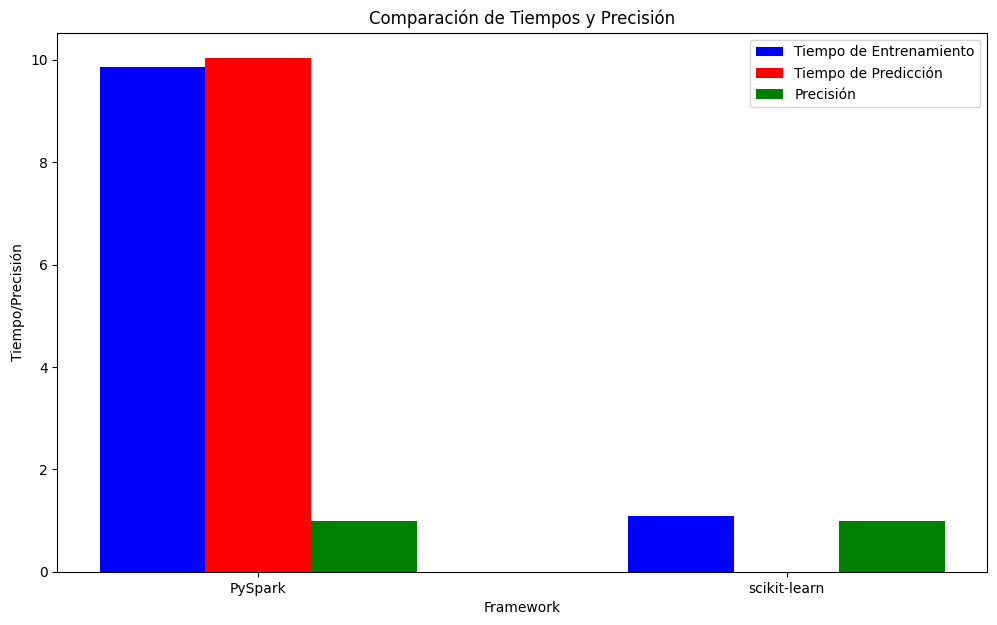

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Valores de tiempo y precisión
training_time_pyspark = 9.865050077438354
prediction_time_pyspark = 10.025771856307983
accuracy_pyspark = 1.0

training_time_sklearn = 1.0816192626953125
prediction_time_sklearn = 0.003161907196044922
accuracy_sklearn = 0.9988056136160047

# Nombres de los enfoques
frameworks = ['PySpark', 'scikit-learn']

# Valores de tiempo de entrenamiento y predicción
training_times = [training_time_pyspark, training_time_sklearn]
prediction_times = [prediction_time_pyspark, prediction_time_sklearn]
accuracies = [accuracy_pyspark, accuracy_sklearn]

# Crear un gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.2
index = np.arange(len(frameworks))

bar1 = ax.bar(index - bar_width, training_times, bar_width, label='Tiempo de Entrenamiento', color='blue')
bar2 = ax.bar(index, prediction_times, bar_width, label='Tiempo de Predicción', color='red')
bar3 = ax.bar(index + bar_width, accuracies, bar_width, label='Precisión', color='green')

ax.set_xlabel('Framework')
ax.set_ylabel('Tiempo/Precisión')
ax.set_title('Comparación de Tiempos y Precisión')
ax.set_xticks(index)
ax.set_xticklabels(frameworks)
ax.legend()

plt.show()


### **DecisionTreeClassifier**

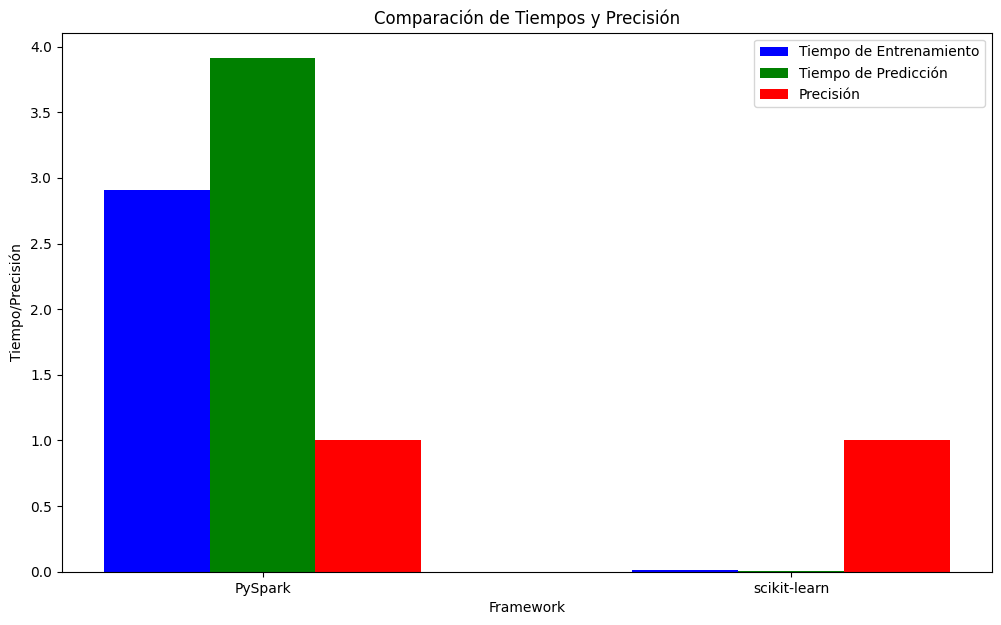

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Valores de tiempo
training_time_pyspark = 2.910039186477661
prediction_time_pyspark = 3.910039186477661
accuracy_pyspark = 1.0

training_time_sklearn = 0.011905431747436523
prediction_time_sklearn = 0.002847909927368164
accuracy_sklearn = 0.9997014034040012

# Nombres de los enfoques
frameworks = ['PySpark', 'scikit-learn']

# Valores de tiempo de entrenamiento y predicción
training_times = [training_time_pyspark, training_time_sklearn]
prediction_times = [prediction_time_pyspark, prediction_time_sklearn]
accuracies = [accuracy_pyspark, accuracy_sklearn]

# Crear un gráfico combinado de barras para tiempos de entrenamiento, predicción y precisión
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.2
index = np.arange(len(frameworks))

bar1 = ax.bar(index - bar_width, training_times, bar_width, label='Tiempo de Entrenamiento', color='blue')
bar2 = ax.bar(index, prediction_times, bar_width, label='Tiempo de Predicción', color='green')
bar3 = ax.bar(index + bar_width, accuracies, bar_width, label='Precisión', color='red')

ax.set_xlabel('Framework')
ax.set_ylabel('Tiempo/Precisión')
ax.set_title('Comparación de Tiempos y Precisión')
ax.set_xticks(index)
ax.set_xticklabels(frameworks)
ax.legend()

plt.show()

**SUPPORT VECTOR MACHINE**

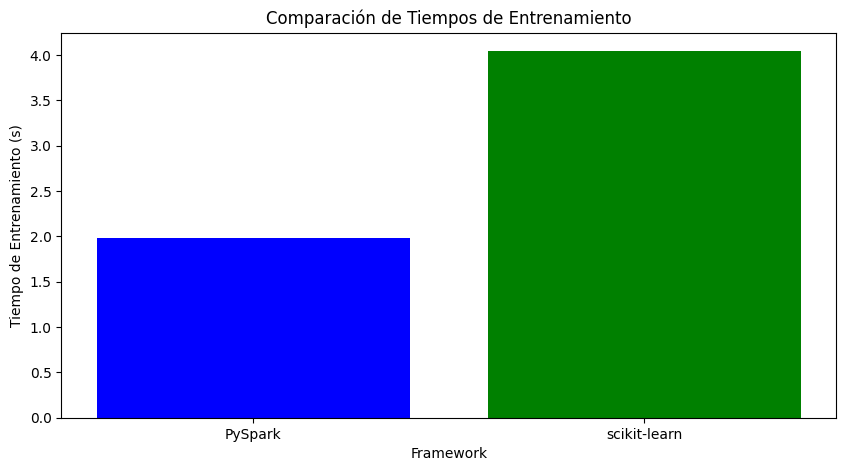

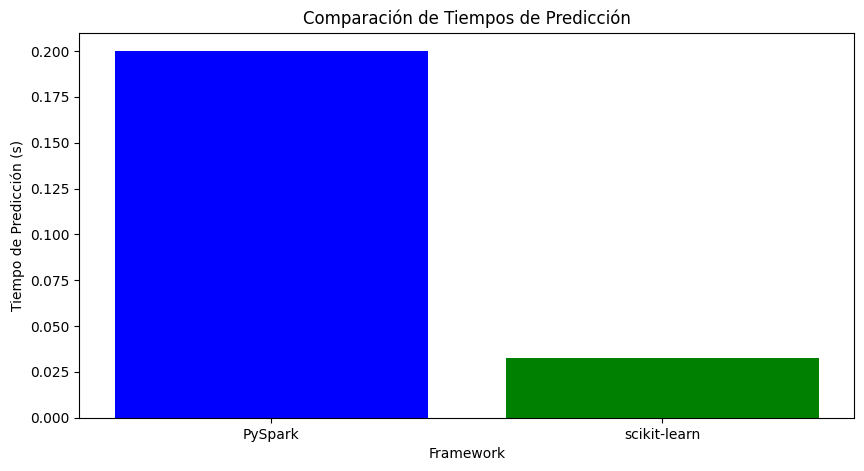

In [ ]:
import matplotlib.pyplot as plt

# Valores de tiempo
training_time_pyspark = 1.98
prediction_time_pyspark = 0.2
accuracy_pyspark = 1.0

training_time_sklearn = 4.042967796325684
prediction_time_sklearn = 0.03271651268005371
accuracy_sklearn = 0.9997014034040012

# Nombres de los enfoques
frameworks = ['PySpark', 'scikit-learn']

# Valores de tiempo de entrenamiento y predicción
training_times = [training_time_pyspark, training_time_sklearn]
prediction_times = [prediction_time_pyspark, prediction_time_sklearn]

# Crear una gráfica de barras para los tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(frameworks, training_times, color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Comparación de Tiempos de Entrenamiento')
plt.show()

# Crear una gráfica de barras para los tiempos de predicción
plt.figure(figsize=(10, 5))
plt.bar(frameworks, prediction_times,color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Predicción (s)')
plt.title('Comparación de Tiempos de Predicción')
plt.show()

**RANDOMFORESTCLASSIFIER**

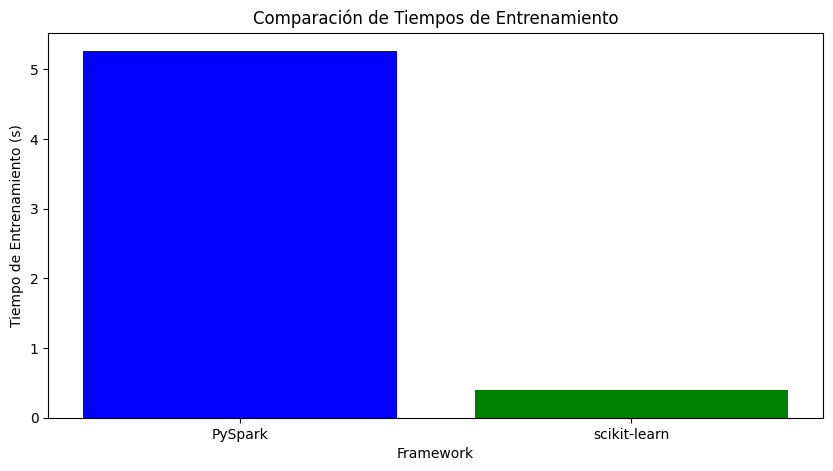

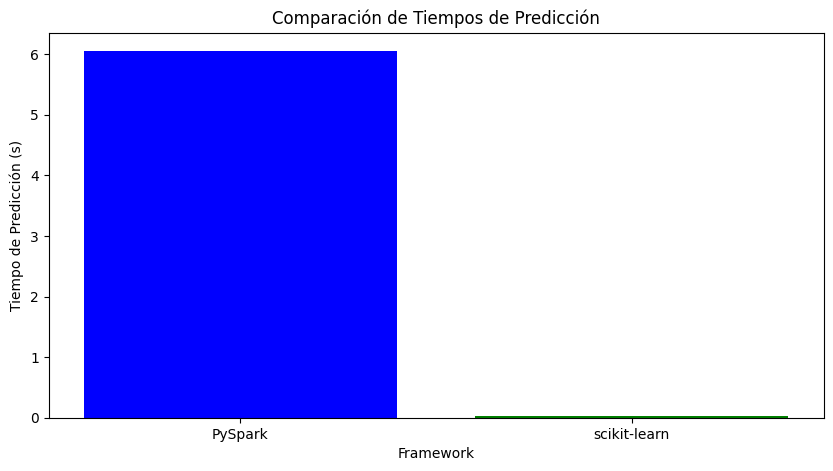

In [ ]:
import matplotlib.pyplot as plt

# Valores de tiempo
training_time_pyspark = 5.261816501617432
prediction_time_pyspark = 6.052491664886475
accuracy_pyspark = 1.0

training_time_sklearn = 0.3966405391693115
prediction_time_sklearn = 0.03271651268005371
accuracy_sklearn = 0.9997014034040012

# Nombres de los enfoques
frameworks = ['PySpark', 'scikit-learn']

# Valores de tiempo de entrenamiento y predicción
training_times = [training_time_pyspark, training_time_sklearn]
prediction_times = [prediction_time_pyspark, prediction_time_sklearn]

# Crear una gráfica de barras para los tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(frameworks, training_times, color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Comparación de Tiempos de Entrenamiento')
plt.show()

# Crear una gráfica de barras para los tiempos de predicción
plt.figure(figsize=(10, 5))
plt.bar(frameworks, prediction_times,color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Predicción (s)')
plt.title('Comparación de Tiempos de Predicción')
plt.show()

### **GaussianNB**

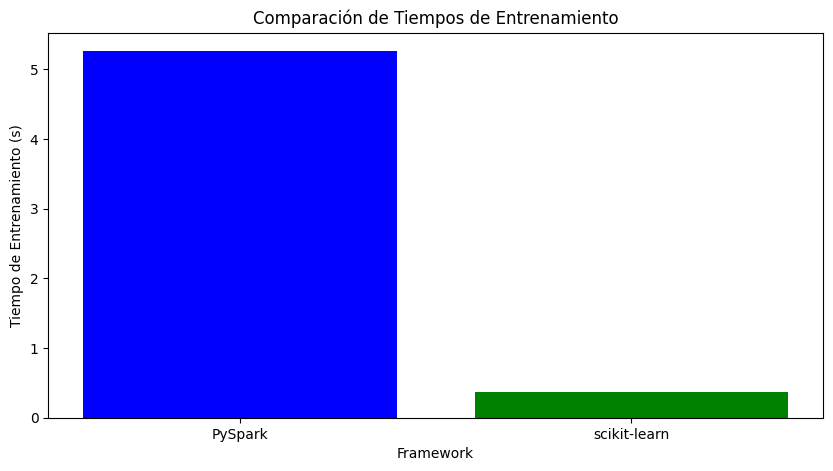

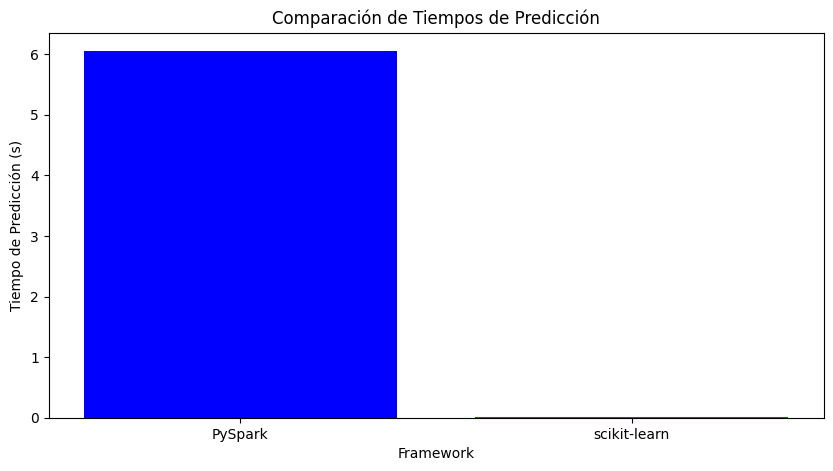

In [ ]:
# Valores de tiempo
training_time_pyspark = 5.261816501617432
prediction_time_pyspark = 6.052491664886475
accuracy_pyspark = 0.99

training_time_sklearn = 0.37
prediction_time_sklearn = 0.01
accuracy_sklearn = 0.99

# Nombres de los enfoques
frameworks = ['PySpark', 'scikit-learn']

# Valores de tiempo de entrenamiento y predicción
training_times = [training_time_pyspark, training_time_sklearn]
prediction_times = [prediction_time_pyspark, prediction_time_sklearn]

# Crear una gráfica de barras para los tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(frameworks, training_times, color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Comparación de Tiempos de Entrenamiento')
plt.show()

# Crear una gráfica de barras para los tiempos de predicción
plt.figure(figsize=(10, 5))
plt.bar(frameworks, prediction_times,color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Predicción (s)')
plt.title('Comparación de Tiempos de Predicción')
plt.show()


**LinearSVC**


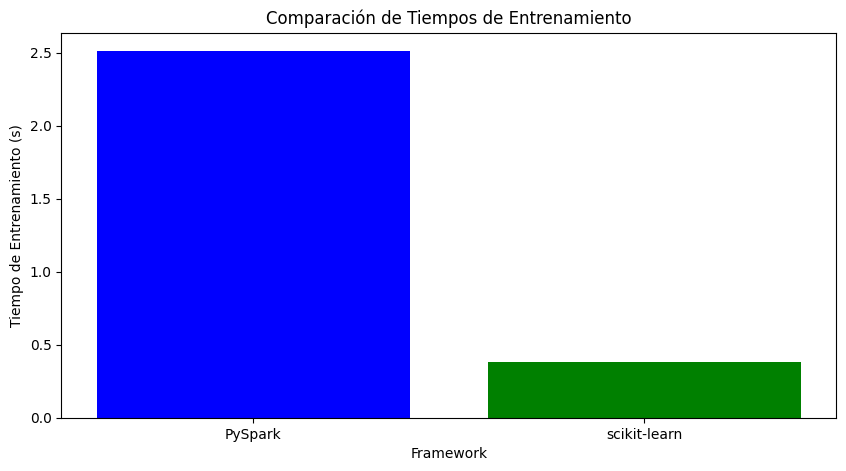

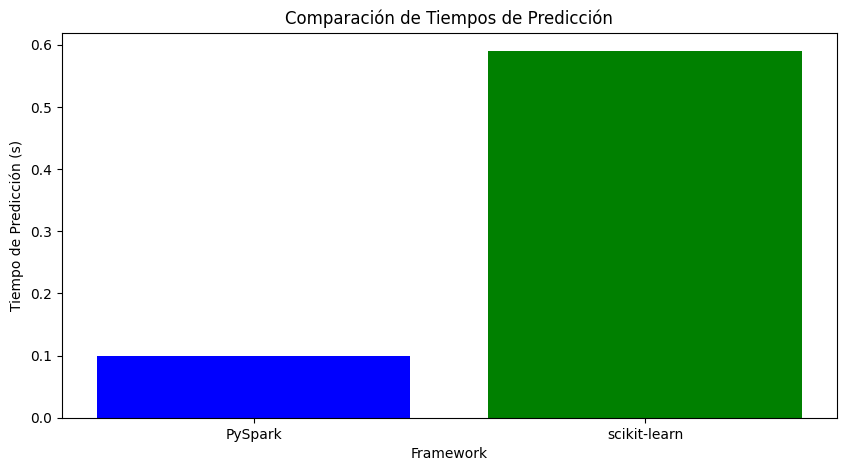

In [ ]:
import matplotlib.pyplot as plt

# Valores de tiempo
training_time_pyspark = 2.51
prediction_time_pyspark = 0.10
accuracy_pyspark = 1.0

training_time_sklearn = 0.38
prediction_time_sklearn = 0.59
accuracy_sklearn = 0.606151

# Nombres de los enfoques
frameworks = ['PySpark', 'scikit-learn']

# Valores de tiempo de entrenamiento y predicción
training_times = [training_time_pyspark, training_time_sklearn]
prediction_times = [prediction_time_pyspark, prediction_time_sklearn]

# Crear una gráfica de barras para los tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(frameworks, training_times, color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Comparación de Tiempos de Entrenamiento')
plt.show()

# Crear una gráfica de barras para los tiempos de predicción
plt.figure(figsize=(10, 5))
plt.bar(frameworks, prediction_times,color=['blue', 'green'])
plt.xlabel('Framework')
plt.ylabel('Tiempo de Predicción (s)')
plt.title('Comparación de Tiempos de Predicción')
plt.show()

### Conclusiones

* De la creacion con el cluster al momento de inciar nos pedia crear una intencion con la variable spark donde aprendimos de como manejar de gran manera los volumenes y que python se limita de gran manera al momento de implementar las cosas donde tenemos en cuenta que actua al agarrar los datosa y modo de almacenamiento de cosas en la vida diaria donde se ve de manera mas de acuerda esto es cuando se empieza el trabajo de los datos en sklern puede dar errores y en spark casi no y el manejo de los datos es mas extenso dado a que spark es un modo de  implementacion con el agarre de datos, puede tardar un poco mas en el procesamiento pero ne resultados es mejor spark.


* Durante el proceso de creación con el cluster, se destacó la importancia de trabajar con la variable Spark para un manejo eficiente de grandes volúmenes de datos. Se observó que Python tiene ciertas limitaciones en la implementación de tareas relacionadas con el procesamiento de datos, especialmente en comparación con Spark. Esto se hizo evidente al manipular y almacenar datos en situaciones cotidianas. En particular, al trabajar con datos en scikit-learn (sklearn), se identificaron posibles errores, mientras que en Spark se experimentaron menos problemas. En última instancia, el manejo de datos se volvió más amplio y versátil con Spark, a pesar de que el procesamiento pueda llevar un poco más de tiempo. En resumen, Spark se destaca por ofrecer resultados más robustos y eficientes.

* El proceso de creación con el cluster subrayó la necesidad de utilizar la variable Spark como una herramienta esencial para gestionar eficazmente grandes volúmenes de datos. Se hizo evidente que Python tiene sus limitaciones en términos de implementación, especialmente al tratar con datos y su almacenamiento en escenarios de la vida real. Al realizar tareas relacionadas con el procesamiento de datos en scikit-learn (sklearn), se encontraron desafíos y posibles errores, lo que contrastó con la experiencia en Spark, donde la probabilidad de errores fue considerablemente menor. Además, el manejo de datos se volvió más versátil y completo gracias a Spark, aunque esto a veces implicara un aumento en el tiempo de procesamiento. En resumen, Spark se reveló como una opción preferible en términos de rendimiento y fiabilidad en comparación con Python